## 통계적 차익거래 팀플 framework


### 20224238 한철환

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 1. 가상의 주가 데이터 생성

In [2]:
#1년은 240일, 1달은 20일로 설정
#상관관계 높은 m 쌍의 가상주식 수익률 시계열 만들기

m=3
n=2*m
T=1200
init_price = np.random.randint(low = 3000, high = 10000, size = n)
corr = np.array([0.95, 0.9, 0.85]) # 상관관계
mu = np.array([0.1, 0.15, 0.2])/240 #연간수익률->일간수익률
sigma = np.array([0.2, 0.3, 0.4]) # 연간변동성
sigma = np.sqrt((sigma**2)/240) # 일간으로 변환

# corr = np.random.rand(m)*0.2+0.8 # 상관관계 0.8~1 랜덤생성
# mu = (np.random.rand(m)*0.1+0.1)/240 # 연평균수익률 10~20%(일간으로 변환) 랜덤생성
# sigma = np.sqrt((np.random.rand(m)*0.2+0.2)**2/240) # 연평균변동성 20~40%(일간으로 변환) 랜덤생성

#가상 수익률 생성
rets = np.random.normal(size = (T, n)) # 정규분포난수 생성
rets[:, 1::2] = corr*rets[:, 0::2] + np.sqrt(1-corr**2)*rets[:, 1::2]  # 상관관계 부여
rets[:, 0::2] = rets[:, 0::2]*sigma + mu #평균, 변동성 부여
rets[:, 1::2] = rets[:, 1::2]*sigma + mu #평균, 변동성 부여
rets[0,:] = 0 #시작시점 리턴 0

stock_names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
returns = pd.DataFrame(rets, columns = stock_names)
disc_rets = np.exp(returns)
prices = disc_rets.cumprod(axis=0)*init_price

returns = returns.stack().to_frame()
returns.columns = ['return']
prices = prices.stack().to_frame()
prices.columns = ['price']

stocks_df = pd.merge(returns, prices, left_index=True, right_index = True)
stocks_df = stocks_df.unstack()

In [3]:
stocks_df['return'].corr()

,A1,A2,B1,B2,C1,C2
A1,1.000000,0.953893,0.022980,0.026221,-0.018850,0.003694
A2,0.953893,1.000000,0.034094,0.031292,-0.014637,0.004233
B1,0.022980,0.034094,1.000000,0.901775,-0.022005,-0.024238
B2,0.026221,0.031292,0.901775,1.000000,-0.014846,-0.027949
C1,-0.018850,-0.014637,-0.022005,-0.014846,1.000000,0.842831
C2,0.003694,0.004233,-0.024238,-0.027949,0.842831,1.000000


In [4]:
stocks_df['return'].describe()

,A1,A2,B1,B2,C1,C2
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.000516,0.000356,0.000093,0.000484,0.001012,0.001534
std,0.013059,0.013124,0.019254,0.019323,0.026219,0.025790
min,-0.043831,-0.039081,-0.065425,-0.070056,-0.080246,-0.069755
25%,-0.008250,-0.008139,-0.012584,-0.012311,-0.017296,-0.015647
50%,0.000724,0.000842,0.000494,0.000336,0.001368,0.000943
75%,0.009119,0.009477,0.013566,0.013778,0.018981,0.020163
max,0.037948,0.038177,0.057873,0.066288,0.083317,0.086428


<AxesSubplot:>

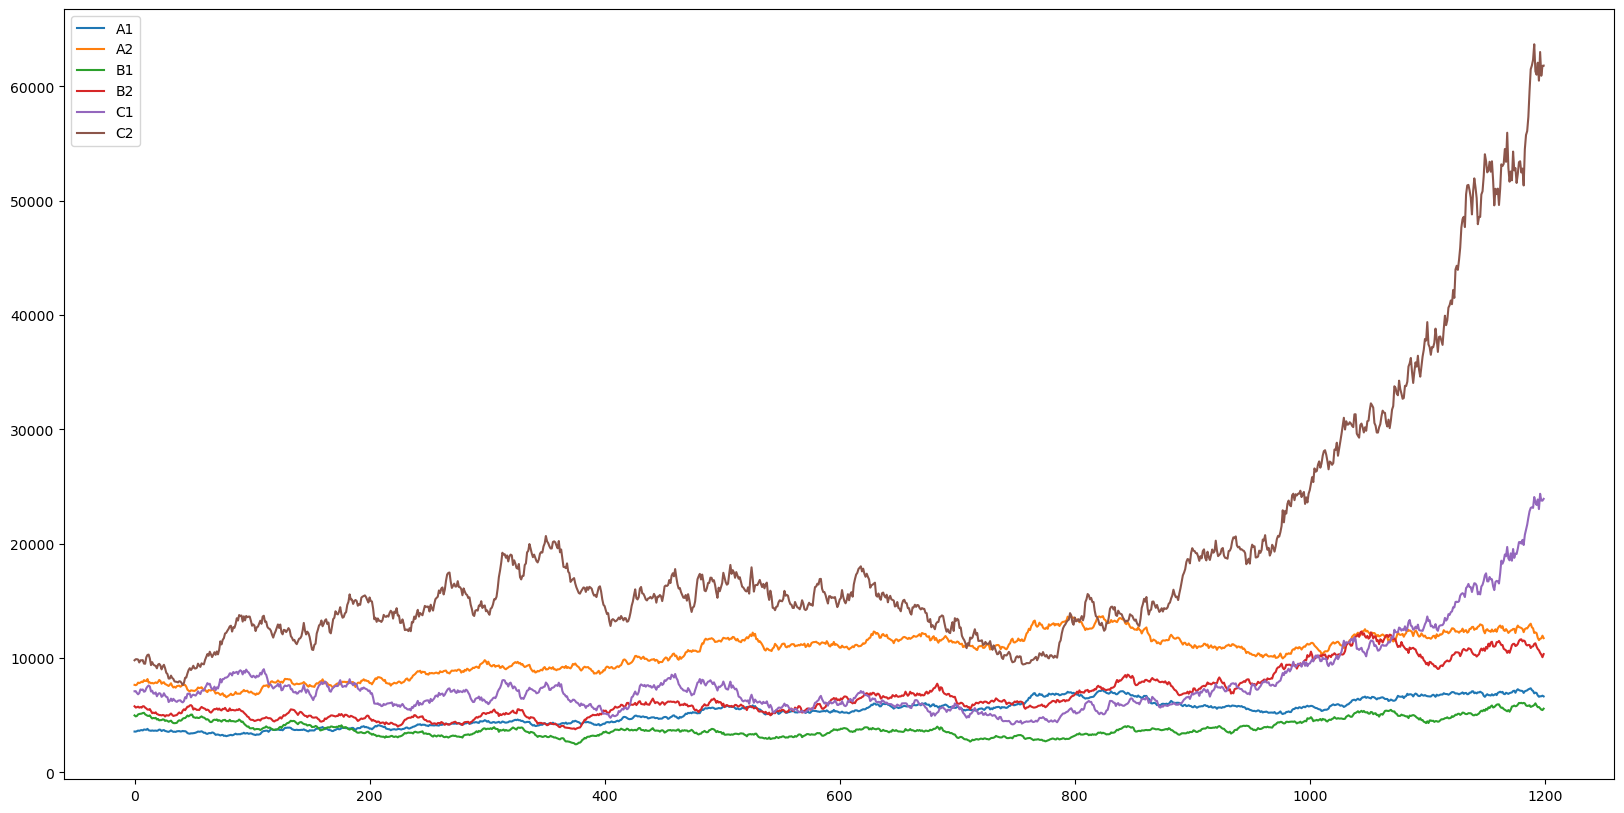

In [5]:
stocks_df['price'].plot(kind='line', figsize = (20,10))


## 2. 페어링 알고리즘

### 2.1. Metric

In [6]:
def logprc_spread(fp, ts, tp, s1, s2, price_df):
    log_price_s1 = np.log(price_df.loc[ts-fp:ts+tp, s1])
    first_logprc_s1 = log_price_s1.loc[ts-fp]
    cum_logret_s1 = log_price_s1 - first_logprc_s1

    log_price_s2 = np.log(price_df.loc[ts-fp:ts+tp, s2])
    first_logprc_s2 = log_price_s2.loc[ts-fp]
    cum_logret_s2 = log_price_s2 - first_logprc_s2

    spread_tseries = cum_logret_s1 - cum_logret_s2
    SSD = (spread_tseries.loc[ts-fp:ts]**2).sum()
    SD = spread_tseries.loc[ts-fp:ts].std()

    return spread_tseries, SSD, SD

### 2.2. Pairing

In [7]:
def pairing(formation_period, trade_start, trading_period, stock_names, stocks_df, select_rule, metric_func):
    n = len(stock_names)
    pairs = {}
    metrics = {}

    for i in range(n):
        if i == n-1:
            break
        for j in range(i+1, n):
            s1, s2 = stock_names[i], stock_names[j]
            pair_name = str(s1)+'-'+str(s2)
            metric_tseries, SSD, SD = metric_func(formation_period, trade_start, trading_period, s1, s2, stocks_df['price'])
            pair_data = [s1, s2, SSD, SD]            
            pairs[pair_name] = pair_data
            metrics[pair_name] = metric_tseries

    pairs_df = pd.DataFrame(pairs, index = ['s1', 's2', 'SSD', 'SD']).T
    pairs_df = pairs_df.sort_values('SSD', ascending = True)
    pairs_df = pairs_df.iloc[select_rule[0]-1:select_rule[1], :]
    pair_names = pairs_df.index

    tseries_idx = stocks_df.loc[trade_start-formation_period:trade_start + trading_period].index
    metrics_df = pd.DataFrame(metrics, index = tseries_idx)
    metrics_df = metrics_df[pair_names]
    return pairs_df, pair_names, metrics_df

In [8]:
formation_period = 240
trade_start = 300
trading_period = 120
select_rule = (1, 5)

pairs_df, pair_names, metrics_df = pairing(formation_period, trade_start, trading_period, stock_names, stocks_df, select_rule, logprc_spread)
pairs_df

,s1,s2,SSD,SD
A1-A2,A1,A2,0.054459,0.014895
B1-B2,B1,B2,2.499308,0.05836
B2-C1,B2,C1,6.255816,0.113893
B1-C1,B1,C1,12.211593,0.1078
A1-C1,A1,C1,12.968392,0.191109


<AxesSubplot:>

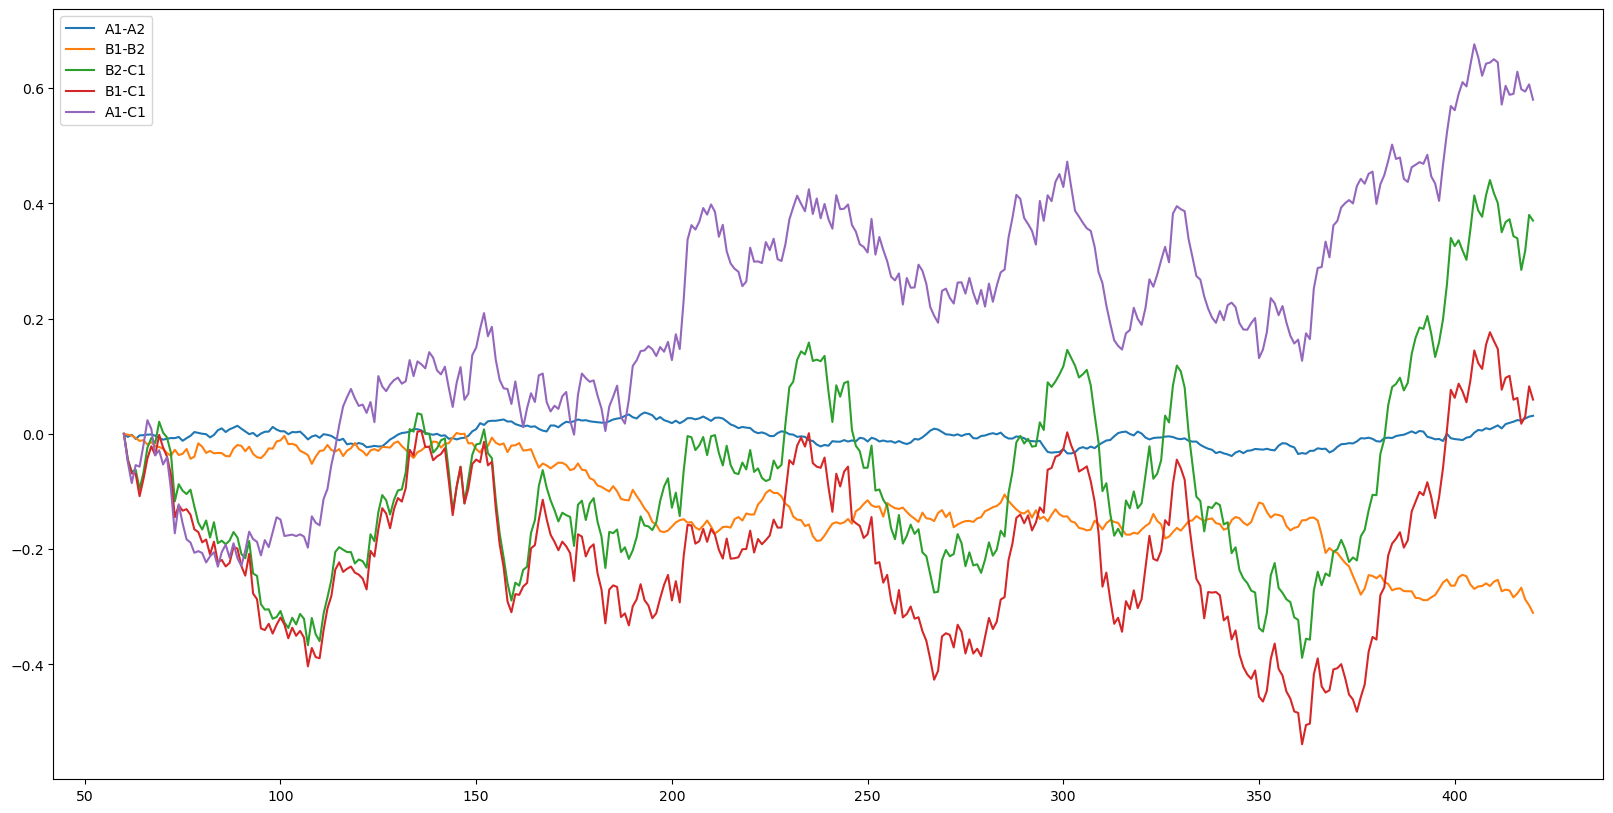

In [9]:
metrics_df.plot(kind='line', figsize=(20,10))

## 3. 진입, 청산시점 결정

In [10]:
def signal_notice(trade_start, trading_period, pairs_df, metrics_df):
    pair_names = pairs_df.index
    metrics_df_trading = metrics_df.loc[trade_start:trade_start + trading_period]

    cutline = np.tile(pairs_df['SD'].values, (len(metrics_df_trading), 1))
    open_range = cutline*2
    close_range = cutline*1

    # open, close로 상태가 바뀌는 순간 찾기
    open_state = (np.abs(metrics_df_trading) >= open_range)
    close_state = (np.abs(metrics_df_trading) <= close_range)
    open_signal = (open_state-open_state.shift(1) == 1)
    close_signal = (close_state-close_state.shift(1) == 1)
    close_signal.iloc[-1,:] = True #마지막날 무조건 종료

    # open, close signal 활용하여 pair별 거래기간 찾기

    trade_dates={}

    for pair in pair_names:
        close_dates = close_signal[close_signal[pair] == True].index
        open_dates = open_signal[open_signal[pair] == True].index

        trades = []
        open_day = np.NaN # 루프 돌 때마다 open_day 초기화

        for i in range(-1, len(close_dates)-1):
            if i == -1:
                if close_dates[0] == metrics_df_trading.index[0]:    # 거래 첫날 closing signal 있는 경우
                    continue
                open_day = open_dates[open_dates<close_dates[0]].min()  # close signal로 나뉘는 구간들에서 가장 빠른 open signal       
                if np.isnan(open_day) == True:      #조건 만족하는 open signal 없는 경우                        
                    continue
                trade = [open_day, close_dates[0]]
                
            else:
                open_day = open_dates[(open_dates > close_dates[i]) * (open_dates < close_dates[i+1])].min()
                if np.isnan(open_day) == True:
                    continue
                trade = [open_day, close_dates[i+1]]
            trades.append(trade)    #거래일 모으기
        
        trade_dates[pair] = trades  #페어별 거래일 dict 입력
    return trade_dates

In [11]:
trade_dates = signal_notice(trade_start, trading_period, pairs_df, metrics_df)
trade_dates

{'A1-A2': [[301, 311], [339, 375], [419, 420]],
 'B1-B2': [],
 'B2-C1': [[345, 379], [398, 420]],
 'B1-C1': [[310, 328], [334, 391]],
 'A1-C1': [[328, 346], [371, 420]]}

## 4. 거래별 손익 계산

In [12]:
def pnl_calculation(pair_names, pairs_df, metrics_df, price_df):
    pnl_data = {}

    for pair in pair_names:
        trades = trade_dates[pair]
        pnls = []

        for trade in trades:
            open, close = trade[0], trade[1]
            trading_day = close-open
            
            if metrics_df.loc[open, pair]>0: # 스프레드>0이면 앞에꺼 숏 뒤에꺼 롱
                long = pairs_df.loc[pair, 's2']
                short = pairs_df.loc[pair, 's1']
            else: # 스프레드<0이면 앞에꺼 롱 뒤에꺼 숏
                long = pairs_df.loc[pair, 's1']
                short = pairs_df.loc[pair, 's2']

            #롱, 숏 거래가격
            long_buy, long_sell = price_df.loc[open, long], price_df.loc[close, long]
            short_buy, short_sell = price_df.loc[open, short], price_df.loc[close, short]

            #각 포지션에 1달러 투자할 때 롱, 숏 손익
            long_pnl = (long_sell-long_buy)/long_buy
            short_pnl = (short_buy-short_sell)/short_buy
            
            # 거래비용은 거래가격의 0.2%, 공매비용 연 5%
            trading_cost = (long_buy+long_sell)*0.002/long_buy + (short_buy+short_sell)*0.002/short_buy         
            short_cost = trading_day/240*0.05

            # 전체 손익 = 롱 + 숏 - 거래비용 - 공매비용
            total_pnl = long_pnl + short_pnl - trading_cost - short_cost

            temp = [open, close, trading_day, total_pnl, long_pnl, short_pnl, -trading_cost, -short_cost]
            pnls.append(temp) # 거래관련 정보들 모으기

        pnl_data[pair] = pnls # 페어별 거래정보 dict 입력
    
    result_df = pd.DataFrame([])
    cols = ['open', 'close', 'trading_days', 'pnl', 'long_pnl', 'short_pnl', 'trading_cost', 'short_cost']

    for pair in pair_names:
        df = pd.DataFrame(pnl_data[pair], columns = cols)
        df['pair'] = pair
        result_df = pd.concat([result_df, df], axis=0)

    return result_df         

In [13]:
result_df = pnl_calculation(pair_names, pairs_df, metrics_df, stocks_df['price'])
result_df

,open,close,trading_days,pnl,long_pnl,short_pnl,trading_cost,short_cost,pair
0,301,311,10,0.011389,-0.034645,0.055936,-0.007819,-0.002083,A1-A2
1,339,375,36,0.006288,0.102287,-0.080134,-0.008365,-0.007500,A1-A2
2,419,420,1,-0.009592,-0.016272,0.014826,-0.007938,-0.000208,A1-A2
0,345,379,34,0.096685,-0.093147,0.204320,-0.007405,-0.007083,B2-C1
1,398,420,22,-0.137222,0.053231,-0.177409,-0.008461,-0.004583,B2-C1
0,310,328,18,0.167062,0.095262,0.083573,-0.008023,-0.003750,B1-C1
1,334,391,57,0.107109,-0.098791,0.225127,-0.007352,-0.011875,B1-C1
0,328,346,18,0.191277,0.114774,0.088306,-0.008053,-0.003750,A1-C1
1,371,420,49,-0.204475,-0.093002,-0.093264,-0.008001,-0.010208,A1-C1


<AxesSubplot:>

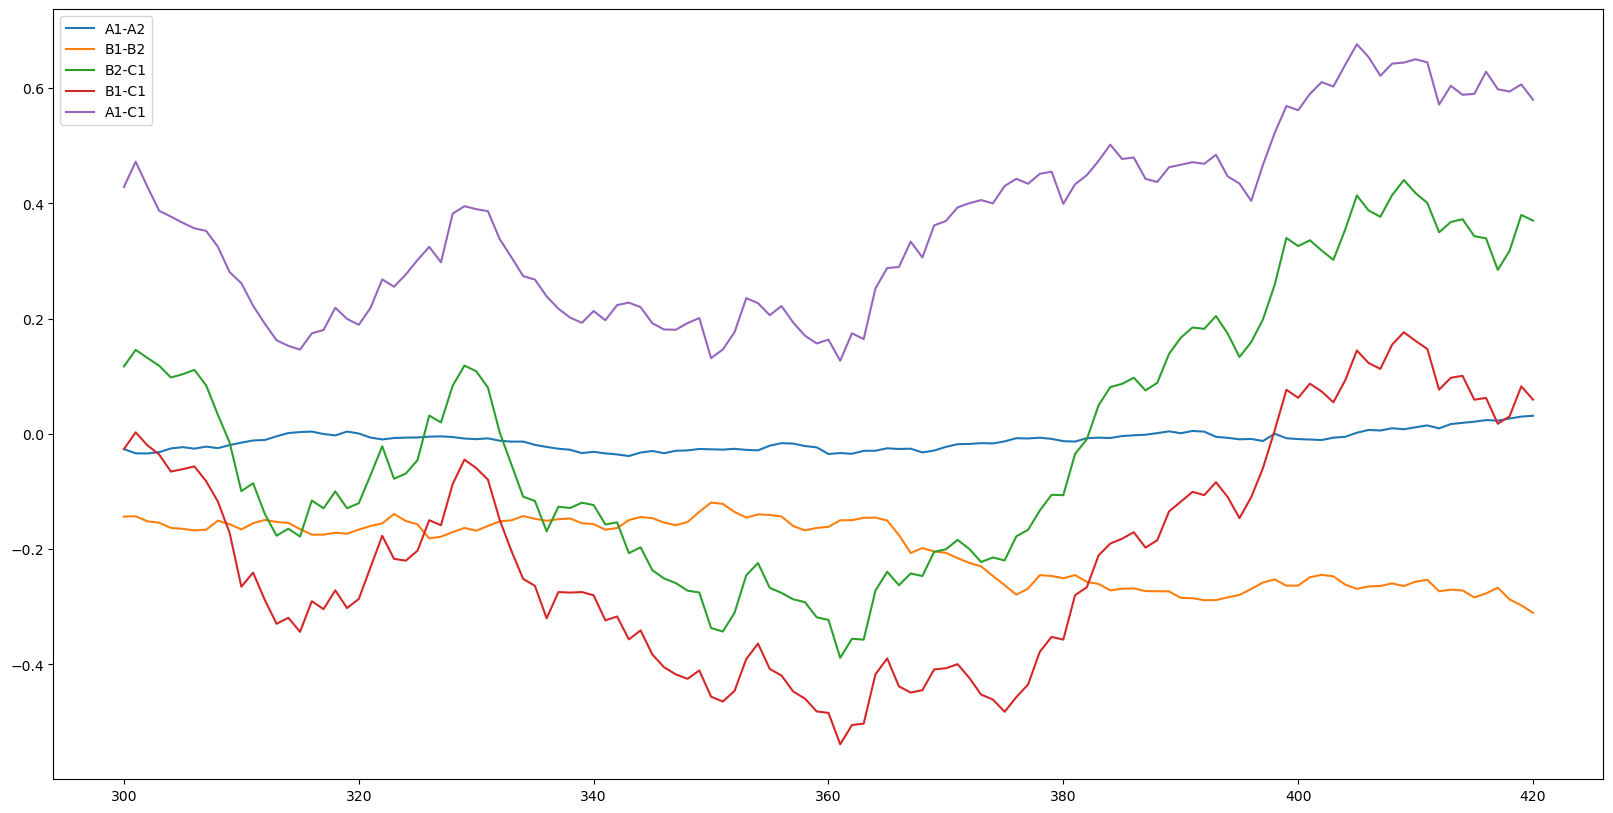

In [14]:
metrics_df.loc[trade_start:trade_start+trading_period].plot(kind='line', figsize = (20,10))

## 5. 거래결과 분석

In [15]:
def result_analysis(result_df):
    grouped_days = result_df['trading_days'].groupby(result_df['pair'])
    days_summary = grouped_days.agg(['count', 'sum'])
    days_summary.columns = ['trading_count', 'total_trading_days']

    grouped_trade = result_df[['pnl', 'long_pnl', 'short_pnl', 'trading_cost', 'short_cost']].groupby(result_df['pair'])
    trade_summary = grouped_trade.sum()
    trade_pct_summary = np.round(trade_summary/trade_summary['pnl'].values.reshape(-1,1)*100, 2)
    trade_summary = pd.concat([days_summary, trade_summary], axis=1)
    trade_pct_summary = pd.concat([days_summary, trade_pct_summary], axis=1)

    grouped_pnl = result_df['pnl'].groupby(result_df['pair'])
    q_1 = lambda x : x.quantile(q=0.25)
    q_3 = lambda x : x.quantile(q=0.75)
    pnl_stats = grouped_pnl.agg(['sum', 'mean', 'std', 'min', q_1, 'median', q_3, 'max'])
    pnl_stats.columns = ['sum', 'mean', 'std', 'min', '25%', 'median', '75%', 'max']

    return trade_summary, trade_pct_summary, pnl_stats

In [16]:
trade_summary, trade_pct_summary, pnl_stats = result_analysis(result_df)

In [17]:
trade_summary

,trading_count,total_trading_days,pnl,long_pnl,short_pnl,trading_cost,short_cost
pair,,,,,,,
A1-A2,3,47,0.008084,0.051370,-0.009372,-0.024121,-0.009792
A1-C1,2,67,-0.013198,0.021772,-0.004957,-0.016053,-0.013958
B1-C1,2,75,0.274170,-0.003529,0.308700,-0.015376,-0.015625
B2-C1,2,56,-0.040538,-0.039916,0.026911,-0.015866,-0.011667


In [18]:
trade_pct_summary

,trading_count,total_trading_days,pnl,long_pnl,short_pnl,trading_cost,short_cost
pair,,,,,,,
A1-A2,3,47,100.0,635.43,-115.93,-298.37,-121.12
A1-C1,2,67,100.0,-164.97,37.56,121.64,105.76
B1-C1,2,75,100.0,-1.29,112.59,-5.61,-5.70
B2-C1,2,56,100.0,98.47,-66.39,39.14,28.78


In [19]:
pnl_stats

,sum,mean,std,min,25%,median,75%,max
pair,,,,,,,,
A1-A2,0.008084,0.002695,0.010942,-0.009592,-0.001652,0.006288,0.008838,0.011389
A1-C1,-0.013198,-0.006599,0.279839,-0.204475,-0.105537,-0.006599,0.092339,0.191277
B1-C1,0.274170,0.137085,0.042393,0.107109,0.122097,0.137085,0.152073,0.167062
B2-C1,-0.040538,-0.020269,0.165397,-0.137222,-0.078746,-0.020269,0.038208,0.096685


코드에서 추가적으로 구현하면 좋을 기능들

금융관련

1)다양한 형태의 페어링 알고리즘

2)베팅 사이즈 조절(손절, 익절, 물타기, 불타기)

3)개별 포지션 말고 전체 계좌상태 관리하는 코드
 * 지금 코드는 모든 포지션에 동일비용, 실제 투자에서는 기존 포지션 열고 닫을때 손익까지 고려해서 다음 투자규모 설정

4)다른 팩터에 대한 노출도 검증

5)거래비용, 공매도비용 등에 대한 처리방법



데이터관련

1)시계열 받아서 train/val/test 나누는 방법(시계열 자기상관 특성을 고려할 때, 랜덤셔플하면 안됨)

2)추가적인 가상 데이터 생성(bootstrap)

3)파라미터 피팅(GridSearch 혹은 목적함수 기반의 gradient descent)